In [1]:
import vedo
import os
import numpy as np
import napari
from skimage import filters, io

from napari_stress import reconstruction, measurements
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import copy

napari.manifest -> 'napari' could not be imported: Could not find file 'builtins.yaml' in module 'napari'


In [2]:
viewer = napari.Viewer()


napari.manifest -> 'napari' could not be imported: Could not find file 'builtins.yaml' in module 'napari'


Create sphere and pad border

In [3]:
radius = 5
padding = 15
sphere = vedo.Sphere(r=radius)
_volume = sphere.binarize(spacing=(0.25, 0.25, 0.25)).tonumpy()
volume = np.zeros(np.asarray(_volume.shape) + 2*padding)
volume[padding: _volume.shape[0]+padding, padding: _volume.shape[1]+padding, padding: _volume.shape[2]+padding] = _volume

In [4]:
sigma = 5
sphere = filters.gaussian(volume, sigma=sigma)
viewer.add_image(sphere)

<Image layer 'sphere' at 0x25d590c6af0>

In [5]:
#io.imsave('sphere_sigma_{sigma}_radius_{radius}_padding_{padding}.tif'.format(sigma=sigma, radius=radius, padding=padding), sphere)

## Load stress output points

(optional)

In [6]:
dest = r'C:\Users\johan\OneDrive\Desktop\validation_stress\synthetic_droplet\results\napari_stress_analysis_and_napari_stress_pointcloud'

100%|██████████| 1/1 [00:00<00:00, 53.05it/s]


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.































































100%|██████████| 1/1 [00:06<00:00,  6.94s/it]































































































































































































































































































































































































































































































































































































































































































































































































































































































































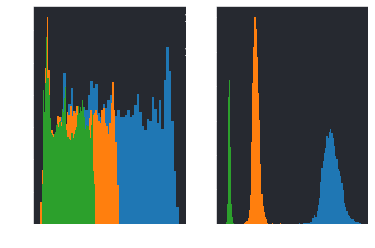

100%|██████████| 1/1 [12:03<00:00, 723.26s/it]


In [7]:
results_reconstruction = reconstruction.reconstruct_droplet(sphere,
                                                            voxelsize=np.asarray([1, 1, 1]),
                                                            target_voxelsize=1,
                                                            n_smoothing_iterations=15,
                                                            n_points=256,
                                                            n_tracing_iterations=3,
                                                            resampling_length=0.75,
                                                            fit_type='fancy',
                                                            edge_type='interior',
                                                            trace_length=20,
                                                            sampling_distance=1,
                                                            remove_outliers=False,
                                                            verbose=False,
                                                            use_dask=False
                                                            )


In [8]:

refined_points = results_reconstruction[3][0]


In [9]:

results_stress_analysis = measurements.comprehensive_analysis(refined_points,
                                                              max_degree=20,
                                                              n_quadrature_points=590,
                                                              gamma=5,
                                                              verbose=False,
                                                              use_dask=False)


100%|██████████| 1/1 [00:00<00:00, 106.12it/s]

100%|██████████| 1/1 [00:00<00:00, 224.05it/s]


100%|██████████| 1/1 [00:00<00:00,  2.57it/s]

100%|██████████| 1/1 [00:00<00:00, 2017.46it/s]

100%|██████████| 1/1 [00:51<00:00, 51.91s/it]


In [10]:
for res in results_stress_analysis:
    if res[2] == 'points':
        viewer.add_points(res[0], **res[1])
    if res[2] == 'vectors':
        viewer.add_vectors(res[0], **res[1])

In [11]:
viewer.layers['Result of lebedev quadrature (droplet)'].features

,mean_curvature,difference_mean_curvature_cartesian_radial_manifold,anisotropic_stress_cell,anisotropic_stress,anisotropic_stress_total_radial
0,0.053248,-0.000114,0.001113,0.000385,0.005727
1,0.054569,-0.000114,0.014327,0.013599,0.002230
2,0.053800,-0.000114,0.005575,0.005907,0.007432
3,0.052926,-0.000114,-0.003164,-0.002832,0.001687
4,0.053023,-0.000114,-0.002256,-0.001859,0.001063
...,...,...,...,...,...
585,0.052160,-0.000114,-0.010053,-0.010488,-0.002085
586,0.052183,-0.000114,-0.009828,-0.010263,-0.004307
587,0.052681,-0.000114,-0.004845,-0.005280,-0.001134
588,0.051842,-0.000114,-0.013234,-0.013668,-0.002948


In [12]:
alpha=0.05
hist_data = np.histogram(viewer.layers['Result of lebedev quadrature (droplet)'].features['anisotropic_stress'], bins='auto', density=True)
hist_dist = stats.rv_histogram(hist_data)
smallest_excluded_value = hist_dist.ppf(alpha)
largest_excluded_value = hist_dist.ppf(1. - alpha)


In [13]:
largest_excluded_value

0.010107556693557741

In [14]:
smallest_excluded_value

-0.00838610902107271

In [15]:
largest_excluded_value - smallest_excluded_value

0.01849366571463045

In [16]:
np.savetxt(os.path.join(dest, 'mean_curvatures.csv'), viewer.layers['Result of lebedev quadrature (droplet)'].features['mean_curvature'])
np.savetxt(os.path.join(dest, 'total_stress.csv'), viewer.layers['Result of lebedev quadrature (droplet)'].features['anisotropic_stress'])
np.savetxt(os.path.join(dest, 'lebedev_points.csv'), viewer.layers['Result of lebedev quadrature (droplet)'].data)
np.savetxt(os.path.join(dest, 'expanded_points.csv'), viewer.layers['Result of fit spherical harmonics (deg = 20'].data)

In [17]:
np.savetxt(os.path.join(dest, 'pointcloud.csv'), refined_points)

In [18]:
dest

'C:\\Users\\johan\\OneDrive\\Desktop\\validation_stress\\synthetic_droplet\\results\\napari_stress_analysis_and_napari_stress_pointcloud'